# Structural Constraint for Molecular Connectomes

In [1]:
import numpy as np
import pub_utils as pu

## Test 1: Load structural connectomes

In [2]:
# List available chemical synapse datasets
datasets = pu.get_available_structural_datasets()
print("Chemical synapse datasets:", datasets)

Chemical synapse datasets: ['Cook2019', 'Cook2019Male', 'Cook2020', 'Varshney2011', 'WhiteA', 'WhiteL4', 'WhiteWhole', 'WitvlietA_07', 'WitvlietA_08', 'WitvlietL1_01', 'WitvlietL1_02', 'WitvlietL1_03', 'WitvlietL1_04', 'WitvlietL2_05', 'WitvlietL3_06', 'Yim2024']


In [3]:
# Load chemical synapse connectome
chem = pu.load_structural_connectome('Cook2019')
print(f"Chemical connectome shape: {chem.shape}")
print(f"Total connections: {(chem > 0).sum().sum()}")

Chemical connectome shape: (302, 302)
Total connections: 3709


## Test 2: Apply structural constraint to molecular connectome

In [4]:
# Assemble molecular connectome
conn = pu.assemble_nt_connectome(
    'glutamate',
    release_markers=['release'],
    release_sources=['reporter:Wang2024'],
    receptor_sources=['sequencing:Fenyves2020']
)
binary = conn['binary']
print(f"Dopamine connectome shape: {binary.shape}")
print(f"Molecular connections: {(binary > 0).sum().sum()}")

Dopamine connectome shape: (302, 302)
Molecular connections: 12321


In [5]:
# Use constrain_assembly to apply to full assembly result
constrained = pu.constrain_assembly(conn, 'Cook2019', mode='binary')

print(f"Original binary connections: {(conn['binary'] > 0).sum().sum()}")
print(f"Constrained binary connections: {(constrained['binary'] > 0).sum().sum()}")
print(f"Constrained count connections: {(constrained['count'] > 0).sum().sum()}")
print(f"Per-pair receptors constrained: {list(constrained['per_pair'].keys())}")
print(f"\nMetadata: {constrained['metadata']}")

Original binary connections: 12321
Constrained binary connections: 814
Constrained count connections: 822
Per-pair receptors constrained: ['avr-14', 'avr-15', 'glc-1', 'glc-2', 'glc-3', 'glc-4', 'glr-1', 'glr-2', 'glr-3', 'glr-4', 'glr-5', 'glr-6', 'glr-7', 'glr-8', 'nmr-1', 'nmr-2']

Metadata: {'structural_dataset': 'Cook2019', 'synapse_type': 'chemical', 'mode': 'binary'}


In [6]:
# Compare using io.compare_connectomes (save to temp files)
import tempfile
import os

with tempfile.TemporaryDirectory() as tmpdir:
    orig_path = os.path.join(tmpdir, 'original.csv')
    const_path = os.path.join(tmpdir, 'constrained.csv')
    
    conn['binary'].to_csv(orig_path)
    constrained['binary'].to_csv(const_path)
    
    comparison = pu.compare_connectomes(
        orig_path, const_path, 
        names=('Original', 'Constrained')
    )
    
print("Comparison summary:")
print(comparison['summary'])

Comparison summary:
                       Metric       Value
0            Neurons (common)    302.0000
1     Connections in Original  12321.0000
2  Connections in Constrained    814.0000
3           Overlap (in both)    814.0000
4            Only in Original  11507.0000
5         Only in Constrained      0.0000
6          Jaccard similarity      0.0661
7         Pearson correlation      0.2401


Weighted mode uses graded weights 0-5 based on percentiles:
  0 = no synapses, 1 = bottom 20%, ..., 5 = top 20%

Non-zero entries: 814

weighted_df shape: (302, 302)


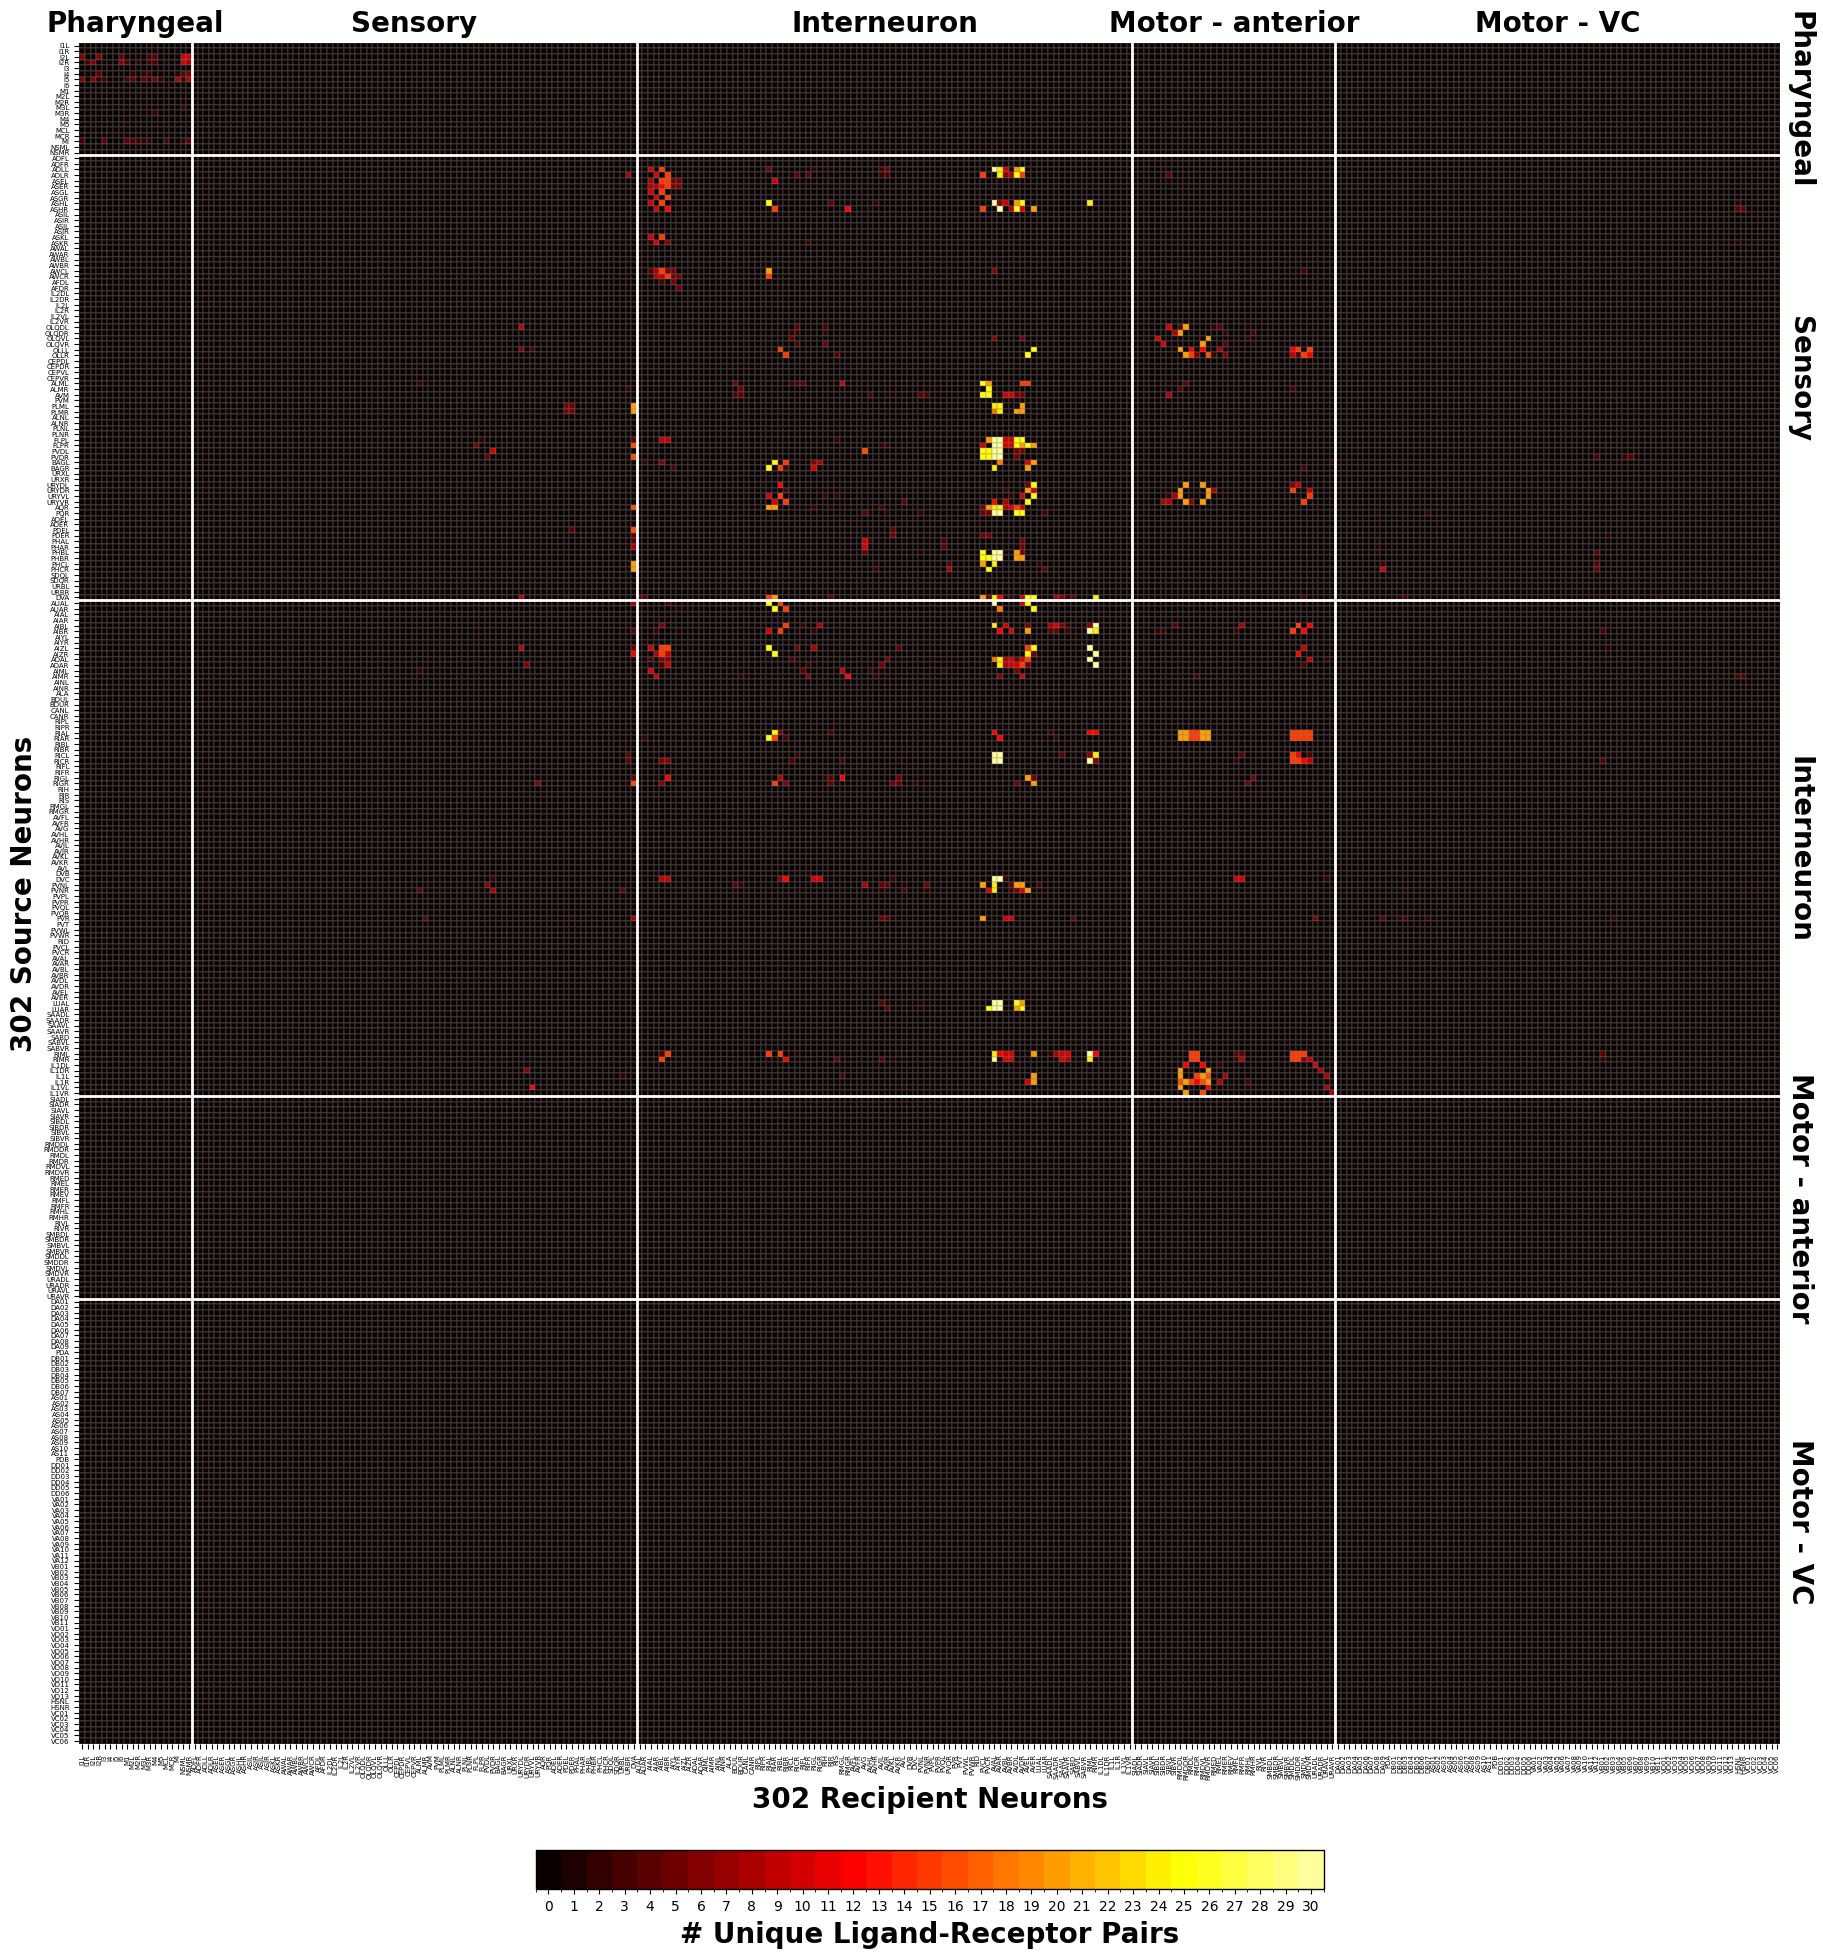

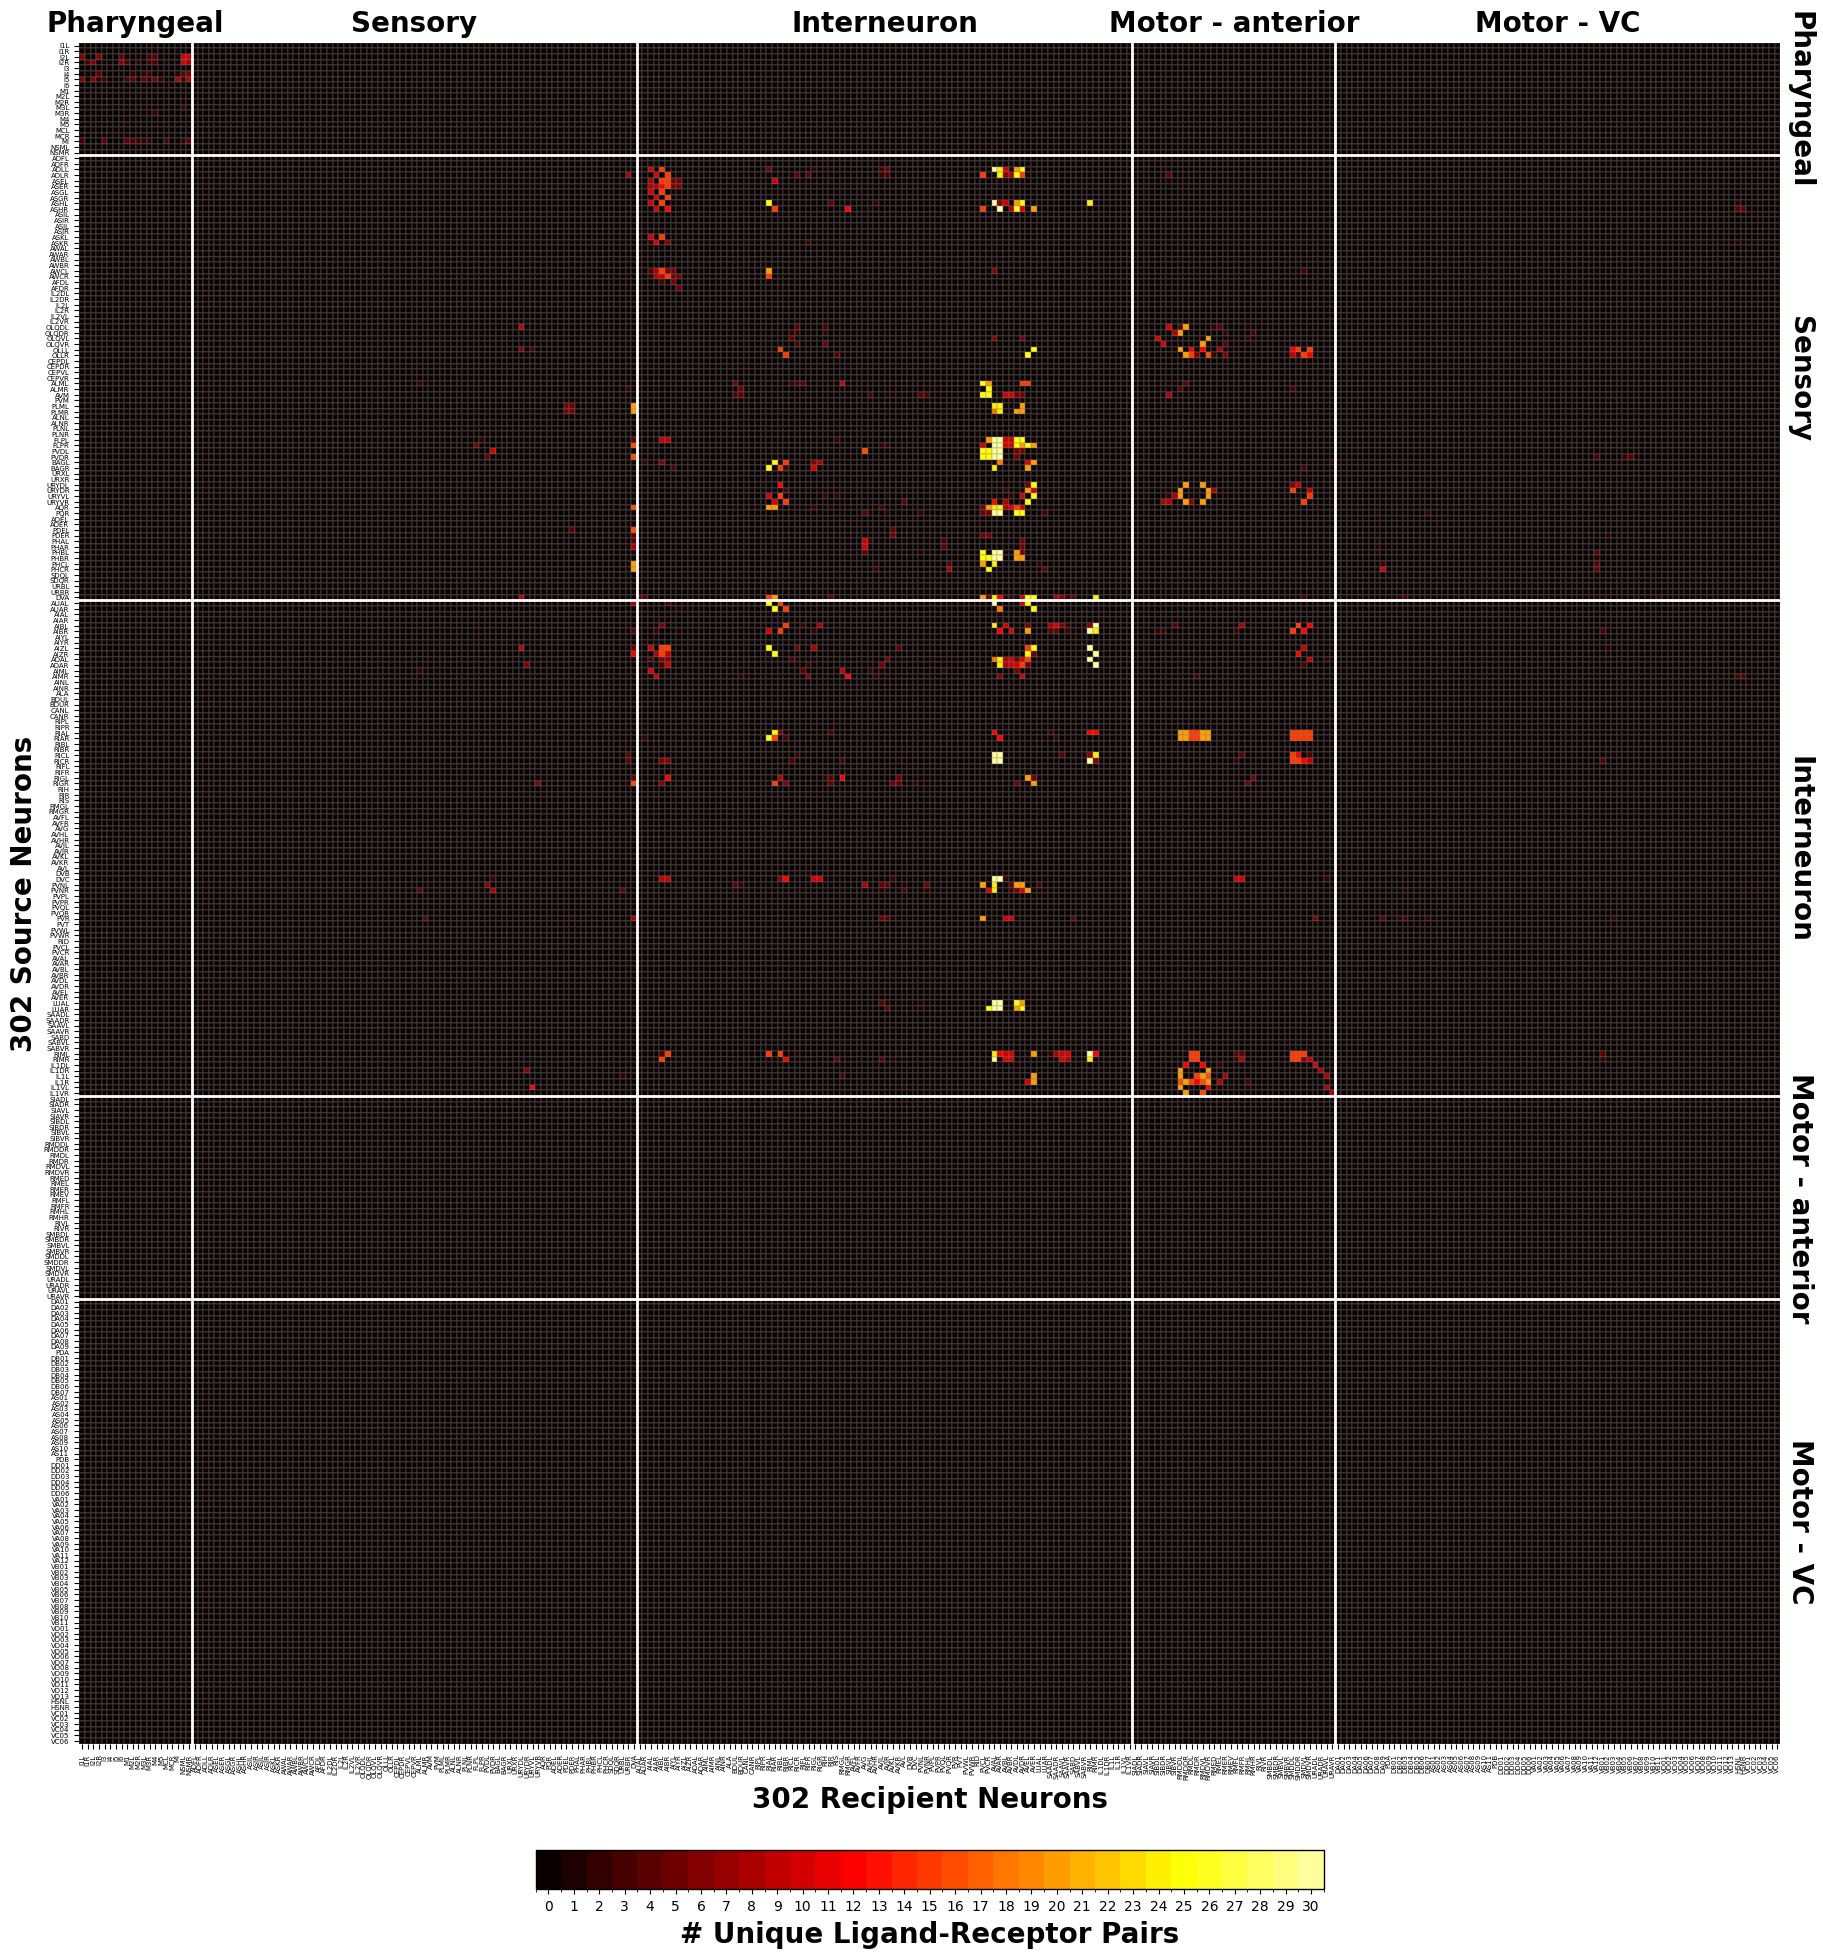

In [7]:
# Test weighted mode (graded 0-5 based on synapse count percentiles)
constrained_weighted = pu.constrain_assembly(conn, 'Cook2019', mode='weighted')

print("Weighted mode uses graded weights 0-5 based on percentiles:")
print("  0 = no synapses, 1 = bottom 20%, ..., 5 = top 20%")
print(f"\nNon-zero entries: {(constrained_weighted['binary'] > 0).sum().sum()}")

# Structure as DataFrame for plotting
weighted_df = constrained_weighted['count'].copy()
print(f"\nweighted_df shape: {weighted_df.shape}")

pu.plot_connectome_matrix(weighted_df)

## Summary

Structural constraint functions (chemical synapses only):
- `pu.load_structural_connectome(dataset)` - Load chemical synapse connectome
- `pu.apply_structural_constraint(molecular, structural, mode)` - Apply to single matrix
- `pu.constrain_assembly(assembly, dataset, mode)` - Apply to full assembly (binary, count, per_pair)
- `pu.get_available_structural_datasets()` - List available datasets
- `pu.compare_connectomes(path_a, path_b)` - Compare two connectomes